In [1]:
%matplotlib notebook
import h5py
import numpy as np
import matplotlib.pyplot as plt
from plotutility import estimatorscope
from pythonwrapper import pwrap

In [2]:
earth_rate_ecef= pwrap.lin_Vector3d([0.000000707063506E-4,-0.000001060595259E-4,0.729211585530000E-4])

In [3]:
np.all(np.isfinite(np.full(3,np.nan)))

False

In [17]:
class Estimator1:
    def __init__(self,alpha):
        self.alpha= alpha
        self.orbit=pwrap.orb_Orbit()
    def input(self,sensors):
        inorbit= pwrap.orb_Orbit(sensors['t'],pwrap.lin_Vector3d(sensors['r']),pwrap.lin_Vector3d(sensors['v']))
        if inorbit.valid():
            self.orbit= inorbit;

    def norm_pos_error_m(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            trueorbit.update(self.orbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.recef())-np.array(self.orbit.recef())))
    def norm_vel_error_mpers(self,sensors,truth):
        #
        trueorbit= pwrap.orb_Orbit(truth['t'],pwrap.lin_Vector3d(truth['r']),pwrap.lin_Vector3d(truth['v']))
        if trueorbit.valid() and self.orbit.valid():
            trueorbit.update(self.orbit.nsgpstime(),earth_rate_ecef)
            return float(np.linalg.norm(np.array(trueorbit.vecef())-np.array(self.orbit.vecef())))

In [18]:
f= h5py.File("test-files/Gracetest.hdf5","r")   
truth= f['truth'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
sensors= f['sensors'][()].astype([('t','i8'),('r','f8',3),('v','f8',3)])
f.close()

<IPython.core.display.Javascript object>


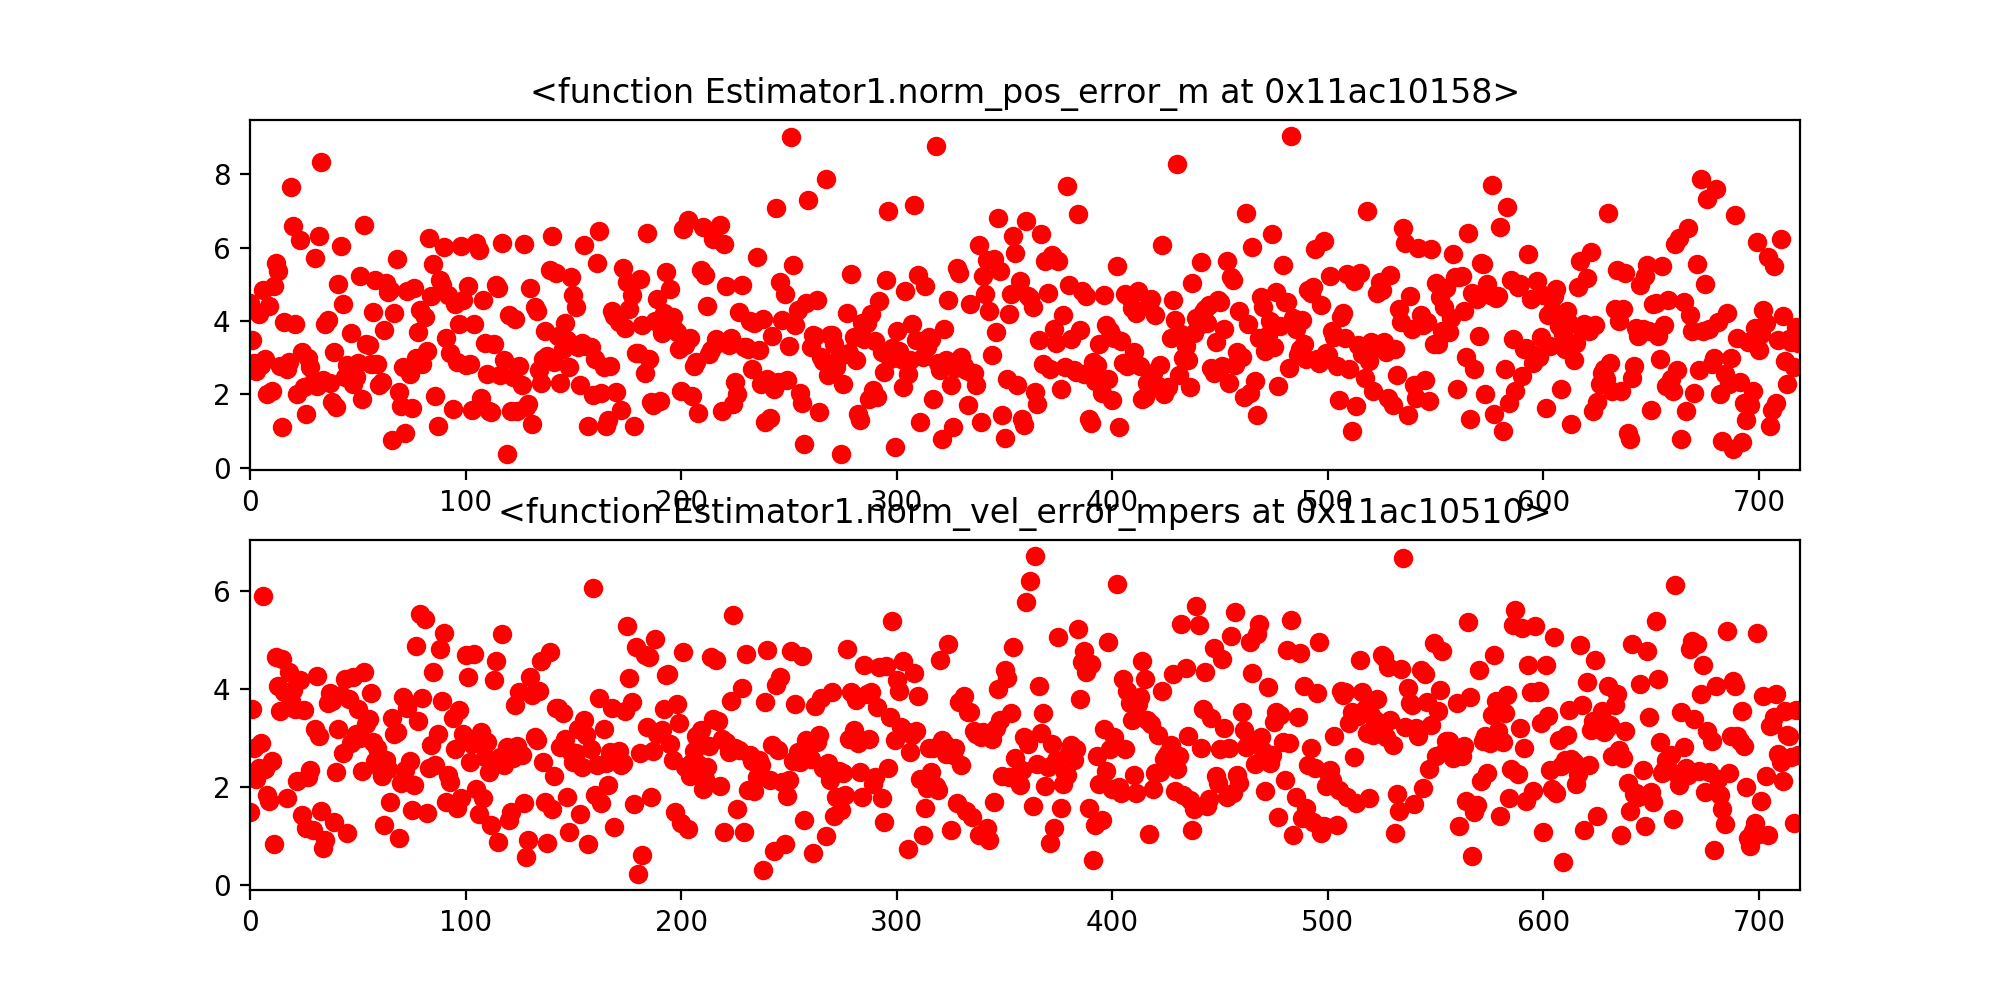

In [19]:
b=[]
samplerate=1000
a= estimatorscope(Estimator1(1.0),truth,sensors,b,samplerate,[Estimator1.norm_pos_error_m,Estimator1.norm_vel_error_mpers])
plt.show()

In [20]:
len(b)

719

In [ ]:
type(0)==float